In [135]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler


sns.set(rc={'figure.figsize':(20,10)})
sns.set_theme(style="whitegrid")

In [34]:
df = pd.read_csv("data/genres_v2.csv", low_memory=False)
print(df.columns)
df.head()

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'genre', 'song_name', 'Unnamed: 0', 'title'],
      dtype='object')


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,id,uri,track_href,analysis_url,duration_ms,time_signature,genre,song_name,Unnamed: 0,title
0,0.831,0.814,2,-7.364,1,0.4200,0.0598,0.013400,0.0556,0.3890,...,2Vc6NJ9PW9gD9q343XFRKx,spotify:track:2Vc6NJ9PW9gD9q343XFRKx,https://api.spotify.com/v1/tracks/2Vc6NJ9PW9gD...,https://api.spotify.com/v1/audio-analysis/2Vc6...,124539,4,Dark Trap,Mercury: Retrograde,NaN,NaN
1,0.719,0.493,8,-7.230,1,0.0794,0.4010,0.000000,0.1180,0.1240,...,7pgJBLVz5VmnL7uGHmRj6p,spotify:track:7pgJBLVz5VmnL7uGHmRj6p,https://api.spotify.com/v1/tracks/7pgJBLVz5Vmn...,https://api.spotify.com/v1/audio-analysis/7pgJ...,224427,4,Dark Trap,Pathology,NaN,NaN
2,0.850,0.893,5,-4.783,1,0.0623,0.0138,0.000004,0.3720,0.0391,...,0vSWgAlfpye0WCGeNmuNhy,spotify:track:0vSWgAlfpye0WCGeNmuNhy,https://api.spotify.com/v1/tracks/0vSWgAlfpye0...,https://api.spotify.com/v1/audio-analysis/0vSW...,98821,4,Dark Trap,Symbiote,NaN,NaN
3,0.476,0.781,0,-4.710,1,0.1030,0.0237,0.000000,0.1140,0.1750,...,0VSXnJqQkwuH2ei1nOQ1nu,spotify:track:0VSXnJqQkwuH2ei1nOQ1nu,https://api.spotify.com/v1/tracks/0VSXnJqQkwuH...,https://api.spotify.com/v1/audio-analysis/0VSX...,123661,3,Dark Trap,ProductOfDrugs (Prod. The Virus and Antidote),NaN,NaN
4,0.798,0.624,2,-7.668,1,0.2930,0.2170,0.000000,0.1660,0.5910,...,4jCeguq9rMTlbMmPHuO7S3,spotify:track:4jCeguq9rMTlbMmPHuO7S3,https://api.spotify.com/v1/tracks/4jCeguq9rMTl...,https://api.spotify.com/v1/audio-analysis/4jCe...,123298,4,Dark Trap,Venom,NaN,NaN


Retirando as columnas que não serão necessárias para as nossas análises

In [35]:
df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'time_signature', 'song_name', 'Unnamed: 0', 'title'], axis=1, inplace=True)
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,0.831,0.814,2,-7.364,1,0.4200,0.0598,0.013400,0.0556,0.3890,156.985,Dark Trap
1,0.719,0.493,8,-7.230,1,0.0794,0.4010,0.000000,0.1180,0.1240,115.080,Dark Trap
2,0.850,0.893,5,-4.783,1,0.0623,0.0138,0.000004,0.3720,0.0391,218.050,Dark Trap
3,0.476,0.781,0,-4.710,1,0.1030,0.0237,0.000000,0.1140,0.1750,186.948,Dark Trap
4,0.798,0.624,2,-7.668,1,0.2930,0.2170,0.000000,0.1660,0.5910,147.988,Dark Trap


Apenas para contexo, uma explicação melhor de cada uma dessas features pode ser encontrada [aqui](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features).  

#### Procurando e Tratando Dados Inválidos

Valores nulos:

In [40]:
df.isnull().sum().sort_values(ascending=False)

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
genre               0
dtype: int64

Valores divergentes do esperado pela documentação:

In [41]:
count = df.shape[0]
df.drop(df[(df['danceability'] > 1) | (df['danceability'] < 0)].index, inplace=True)
print("Dropped by danceability: ", count - df.shape[0])

Dropped by danceability:  0


In [42]:
count = df.shape[0]
df.drop(df[(df['energy'] > 1) | (df['energy'] < 0)].index, inplace=True)
print("Dropped by energy: ", count - df.shape[0])

Dropped by energy:  0


In [43]:
count = df.shape[0]
df.drop(df[(df['key'] > 11) | (df['key'] < -1)].index, inplace=True)
print("Dropped by key: ", count - df.shape[0])

Dropped by key:  0


In [45]:
count = df.shape[0]
df.drop(df[(df['loudness'] > 0) | (df['loudness'] < -60)].index, inplace=True)
print("Dropped by loudness: ", count - df.shape[0])

Dropped by loudness:  0


In [46]:
count = df.shape[0]
df.drop(df[(df['mode'] != 1) & (df['mode'] != 0)].index, inplace=True)
print("Dropped by mode: ", count - df.shape[0])

Dropped by mode:  0


In [47]:
count = df.shape[0]
df.drop(df[(df['speechiness'] > 1) | (df['speechiness'] < 0)].index, inplace=True)
print("Dropped by speechiness: ", count - df.shape[0])

Dropped by speechiness:  0


In [48]:
count = df.shape[0]
df.drop(df[(df['acousticness'] > 1) | (df['acousticness'] < 0)].index, inplace=True)
print("Dropped by acousticness: ", count - df.shape[0])

Dropped by acousticness:  0


In [49]:
count = df.shape[0]
df.drop(df[(df['instrumentalness'] > 1) | (df['instrumentalness'] < 0)].index, inplace=True)
print("Dropped by instrumentalness: ", count - df.shape[0])

Dropped by instrumentalness:  0


In [50]:
count = df.shape[0]
df.drop(df[(df['liveness'] > 1) | (df['liveness'] < 0)].index, inplace=True)
print("Dropped by liveness: ", count - df.shape[0])

Dropped by liveness:  0


In [51]:
count = df.shape[0]
df.drop(df[(df['valence'] > 1) | (df['valence'] < 0)].index, inplace=True)
print("Dropped by valence: ", count - df.shape[0])

Dropped by valence:  0


#### Análise Inicial dos Dados

Numero de dados por gênero:

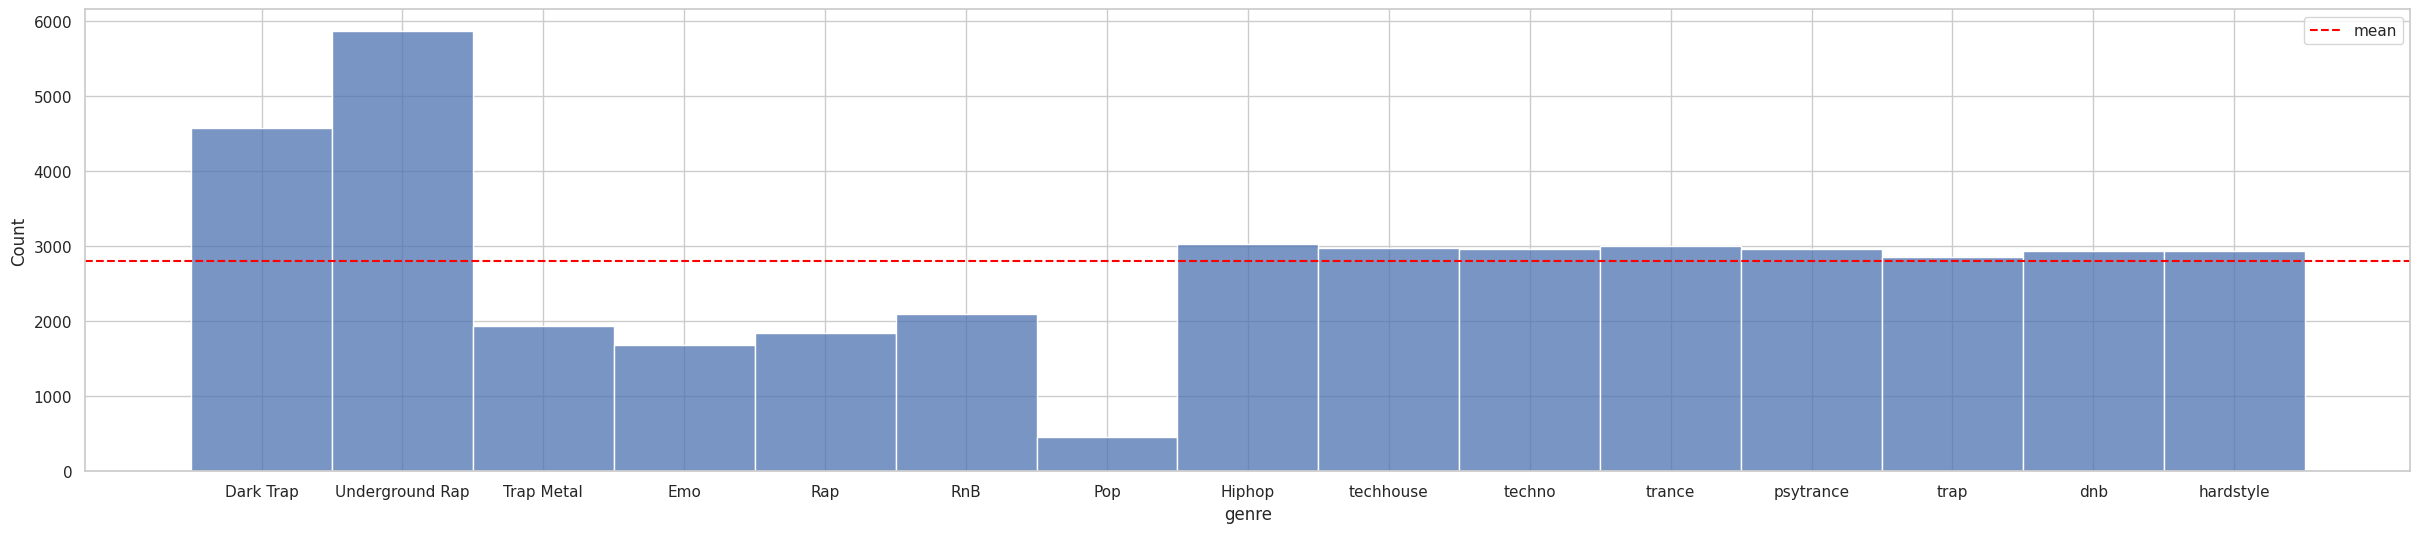

In [124]:
mean_count = df.groupby('genre').count().mean()[0]

f, ax = plt.subplots(1, 1, figsize=(30, 6))
sns.histplot(df, x='genre', ax=ax)
ax.axhline(mean_count, linestyle='dashed', label='mean', color='red')
ax.legend()

Como podemos ver, o dataset está bem desbalanceado. Para balancear vamos fazer duas coisas:
* Retirar o genero 'Pop', já que o mesmo possui poucos dados quanto comparado ao resto.
* Diminuir o número de músicas do DarkTrap e Undergroup Rap para o valor médio de músicas por gênero.

In [125]:
df.drop(df[df['genre'] == 'Pop' ].index, inplace=True)

dt_count = df[df['genre'] == 'Dark Trap'].shape[0]
df.drop(df[df['genre'] == 'Dark Trap'].sample(int(dt_count - mean_count)).index, inplace=True)

ur_count = df[df['genre'] == 'Underground Rap'].shape[0]
df.drop(df[df['genre'] == 'Underground Rap'].sample(int(ur_count - mean_count)).index, inplace=True)

Desse modo, teremos:

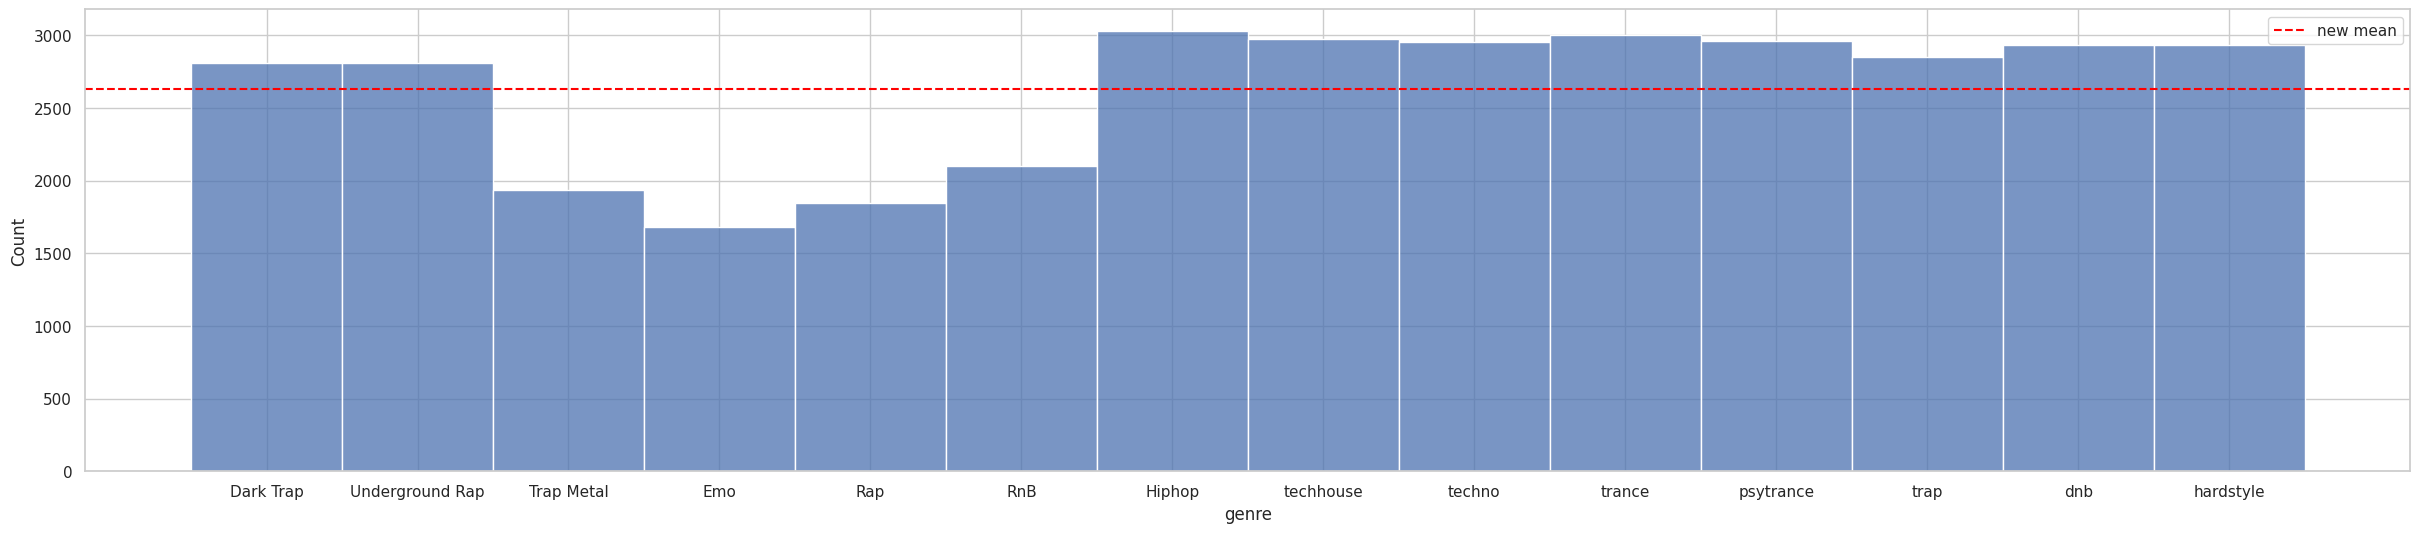

In [134]:
mean_count = df.groupby('genre').count().mean()[0]

f, ax = plt.subplots(1, 1, figsize=(30, 6))
sns.histplot(df, x='genre', ax=ax)
ax.axhline(mean_count, linestyle='dashed', label='new mean', color='red')
ax.legend()

Verificando a correlação entre os dados

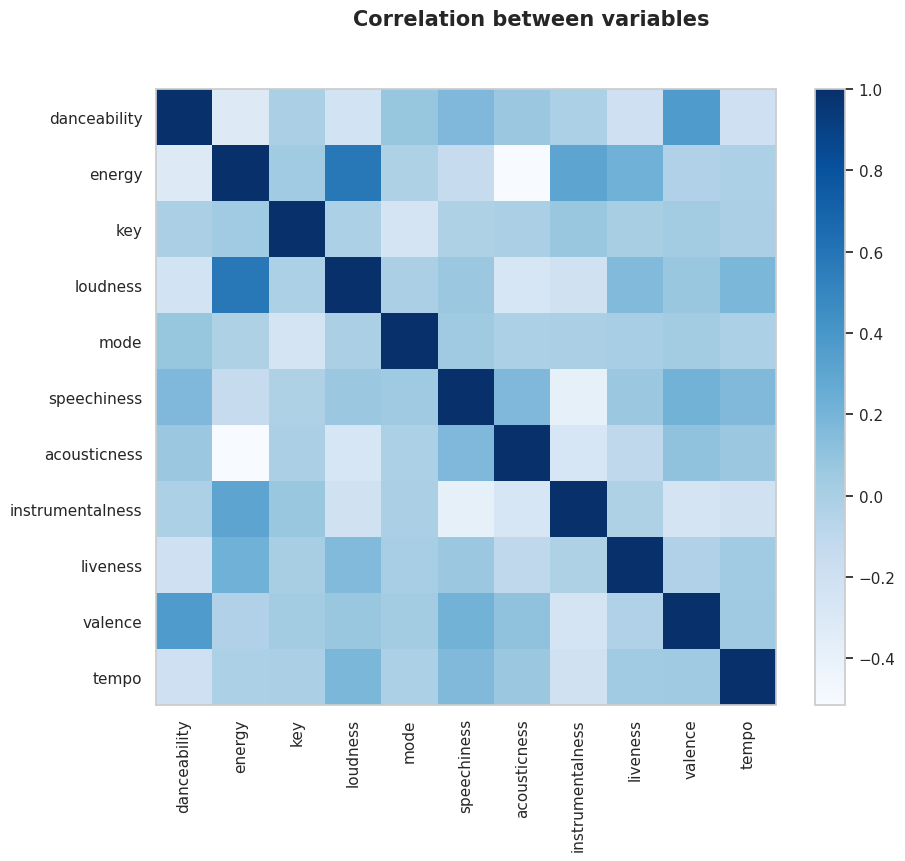

In [141]:
corr = df.corr()

#Plot Correlation Matrix using Matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(corr, cmap='Blues', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr)), corr.columns);
plt.suptitle('Correlation between variables', fontsize=15, fontweight='bold')
plt.grid(False)
plt.show()

##### Normalizando os dados

In [138]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

scaler = StandardScaler()
X = scaler.fit_transform(X)